### Comparison

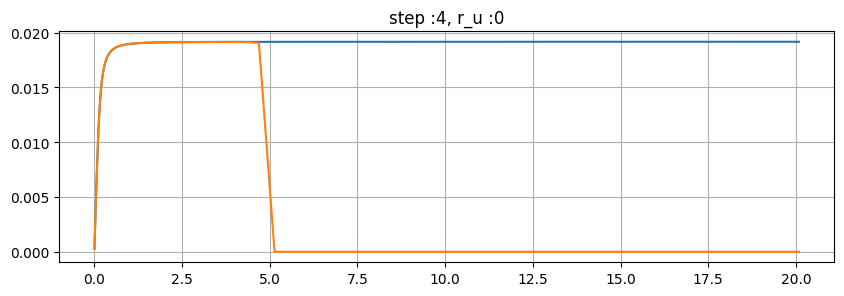

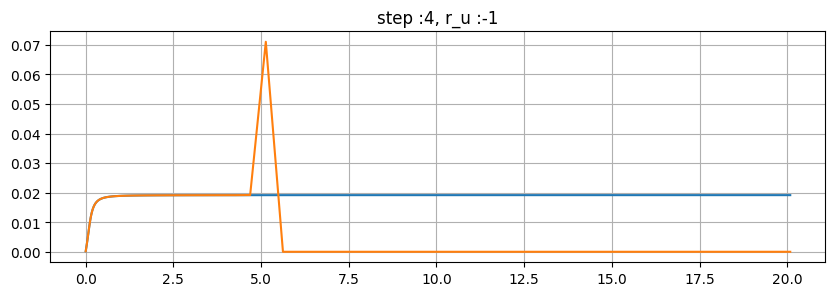

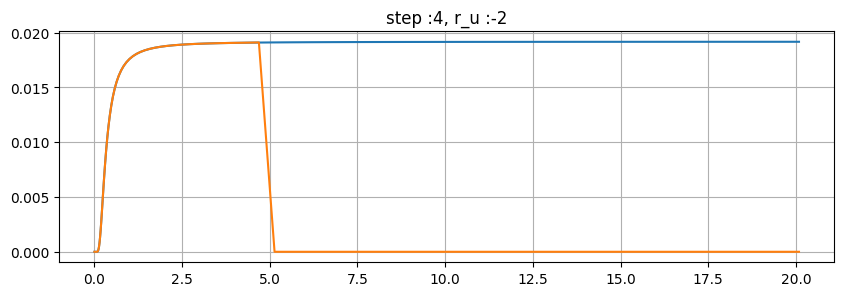

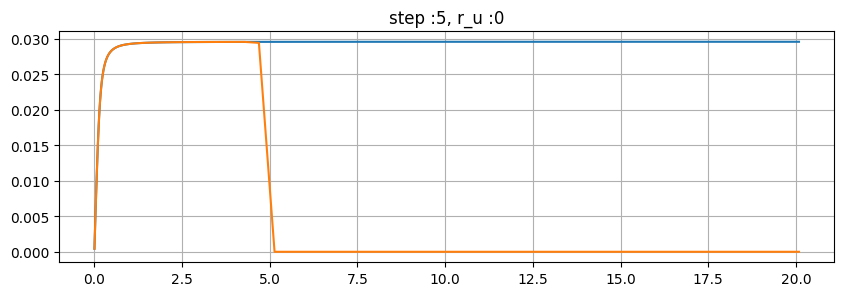

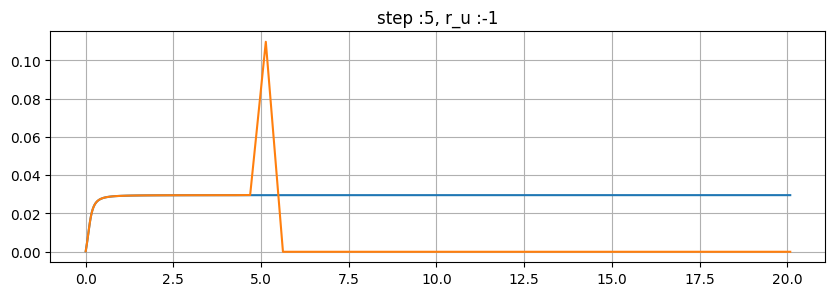

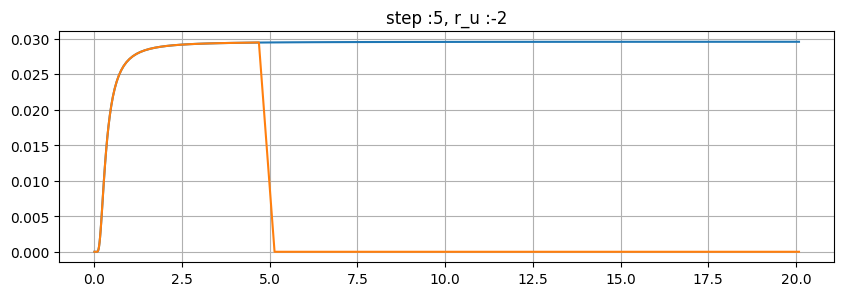

In [25]:
import torch
import numpy as np
from scipy.integrate import quad
from scipy.special import erf
import matplotlib.pyplot as plt
import math

def integral_quad(lambda_s, lambda_t, lambda_u, betas):
    def _integrand(x, beta):
        return np.exp(x - beta**2 * (x - lambda_u)**2)
    results = []
    for beta in betas:
        val, _ = quad(_integrand, lambda_s, lambda_t, args=(beta,))
        results.append(val)
    return np.array(results)

def integral_numpy(lambda_s, lambda_t, lambda_u, betas):
    sqrt_pi = np.sqrt(np.pi)
    betas_inv = 1.0 / betas
    betas_sq_inv = 1.0 / (betas**2)

    prefactor = 0.5 * sqrt_pi * betas_inv * np.exp(lambda_u + 0.25 * betas_sq_inv)

    err_arg_t = betas*(lambda_t - lambda_u) - 0.5*betas_inv
    err_arg_s = betas*(lambda_s - lambda_u) - 0.5*betas_inv
    return prefactor * (erf(err_arg_t) - erf(err_arg_s))

def integral_torch(lambda_s, lambda_t, lambda_u, betas):
    lambda_s = torch.tensor(lambda_s, device='cuda:0')
    lambda_t = torch.tensor(lambda_t, device='cuda:0')
    lambda_u = torch.tensor(lambda_u, device='cuda:0')
    betas = torch.tensor(betas, device='cuda:0')

    sqrt_pi = math.sqrt(math.pi)
    betas_inv = 1.0 / betas
    betas_sq_inv = 1.0 / (betas**2)

    prefactor = 0.5 * sqrt_pi * betas_inv * torch.exp(lambda_u + 0.25 * betas_sq_inv)

    err_arg_t = betas*(lambda_t - lambda_u) - 0.5*betas_inv
    err_arg_s = betas*(lambda_s - lambda_u) - 0.5*betas_inv
    ret = prefactor * (torch.erf(err_arg_t) - torch.erf(err_arg_s))
    return ret.data.cpu().numpy()

def integral_torch_log(lambda_s, lambda_t, lambda_u, betas):
    lambda_s = torch.tensor(lambda_s, device='cuda:0')
    lambda_t = torch.tensor(lambda_t, device='cuda:0')
    lambda_u = torch.tensor(lambda_u, device='cuda:0')
    betas = torch.tensor(betas, device='cuda:0')

    sqrt_pi = math.sqrt(math.pi)
    betas_inv = 1.0 / betas
    betas_sq_inv = 1.0 / (betas**2)

    prefactor = np.log(0.5) + np.log(sqrt_pi) + torch.log(betas_inv) + (lambda_u + 0.25 * betas_sq_inv)
    err_arg_t = betas*(lambda_t - lambda_u) - 0.5*betas_inv
    err_arg_s = betas*(lambda_s - lambda_u) - 0.5*betas_inv
    erf_t = torch.erf(err_arg_t)
    erf_s = torch.erf(err_arg_s)
    ret = prefactor + torch.log(torch.erf(err_arg_t) - torch.erf(err_arg_s))
    #ret = prefactor + torch.log(erf_t) + torch.log(1-erf_s/erf_t)
    ret = torch.exp(ret)
    return ret.data.cpu().numpy()

lambda_0 = -5.0778
lambda_1 = 5.7618
NFE = 25
delta_lambda = (lambda_1 - lambda_0) / NFE
log_scales = np.linspace(-6, 3, 100)
scales = np.exp(log_scales)
betas = 1/scales * delta_lambda

for step in range(4, 6):
    for r_u in [0, -1, -2]:
        lambda_s = lambda_0 + delta_lambda * step
        lambda_t = lambda_0 + delta_lambda * (step+1)
        lambda_u = lambda_t + delta_lambda * r_u
        
        int_quad = integral_quad(lambda_s, lambda_t, lambda_u, betas)
        #int_closed = integral_numpy(lambda_s, lambda_t, lambda_u, betas)
        #int_torch = integral_torch(lambda_s, lambda_t, lambda_u, betas)
        int_torch_log = integral_torch_log(lambda_s, lambda_t, lambda_u, betas)

        plt.figure(figsize=[10, 3])
        plt.title('step :' + str(step) + ', r_u :' + str(r_u))
        plt.plot(scales, int_quad, label='quad')
        #plt.plot(scales, int_closed, label='closed form')
        #plt.plot(scales, int_torch, label='torch')
        plt.plot(scales, int_torch_log, label='torch log')
        plt.grid()
        plt.show()

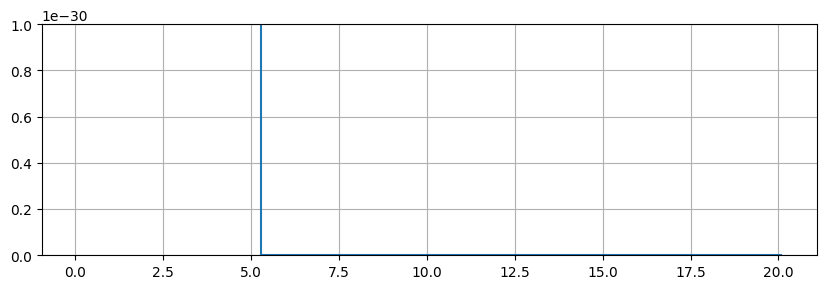

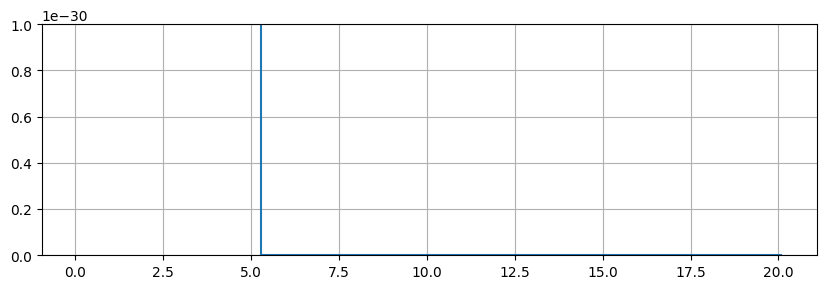

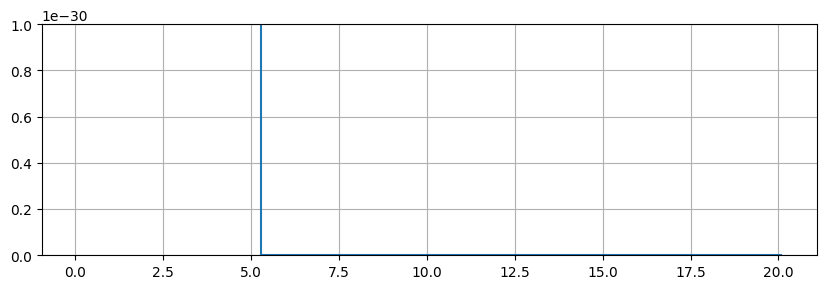

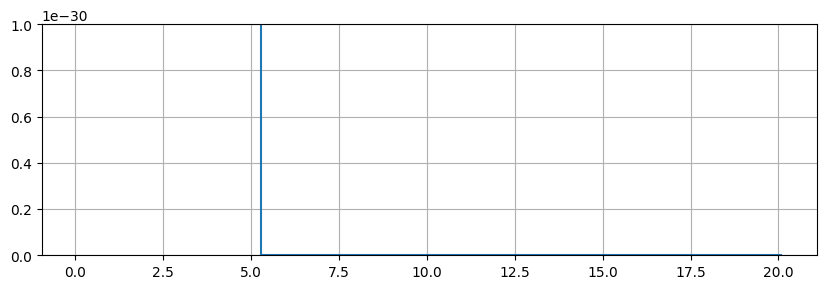

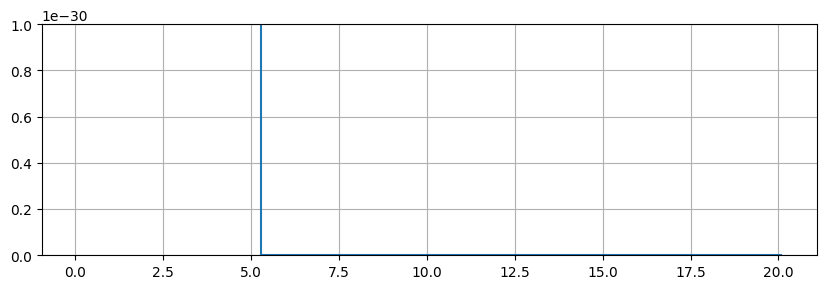

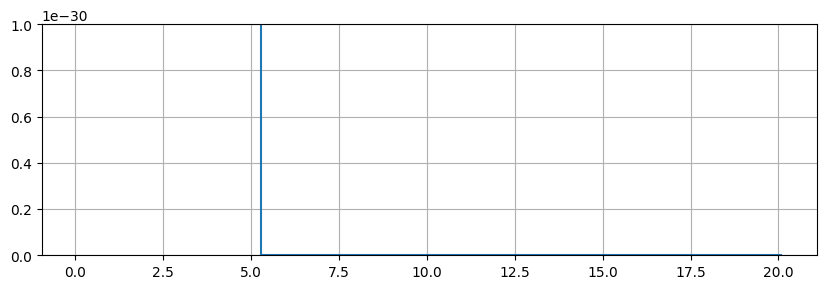

In [ ]:
import torch
import numpy as np
from scipy.integrate import quad
from scipy.special import erf, erfcx
import matplotlib.pyplot as plt
import math

lambda_0 = -5.0778
lambda_1 = 5.7618
NFE = 25
delta_lambda = (lambda_1 - lambda_0) / NFE
log_scales = np.linspace(-3, 3, 100)
scales = np.exp(log_scales)
betas = 1/scales * delta_lambda

for step in range(4, 6):
    for r_u in [0, -1, -2]:
        lambda_s = lambda_0 + delta_lambda * step
        lambda_t = lambda_0 + delta_lambda * (step+1)
        lambda_u = lambda_t + delta_lambda * r_u
        
        upper = erf(betas*(lambda_t-lambda_u)+1/(2*betas))
        lower = erf(betas*(lambda_s-lambda_u)+1/(2*betas))

        plt.figure(figsize=[10, 3])
        #plt.plot(scales, upper, label='upper')
        #plt.plot(scales, lower, label='lower')
        plt.plot(scales, upper - lower, label='lower')
        plt.grid()
        plt.ylim([0, 1e-30])
        plt.show()

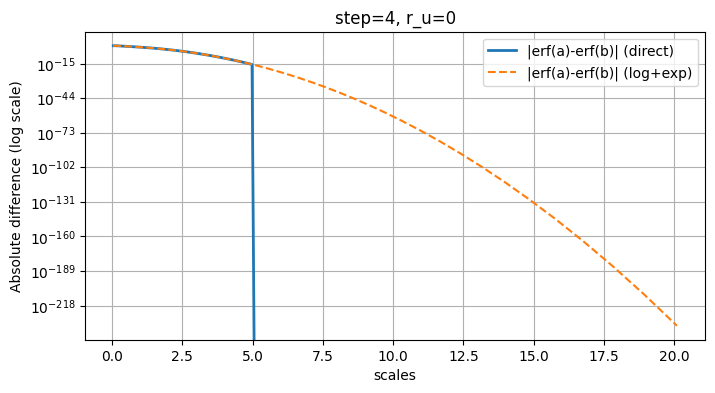

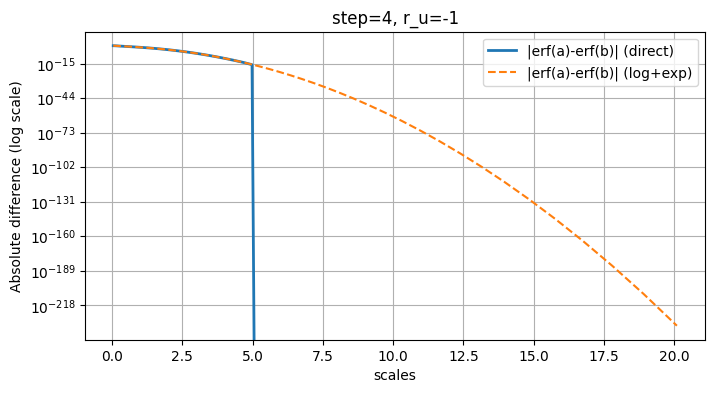

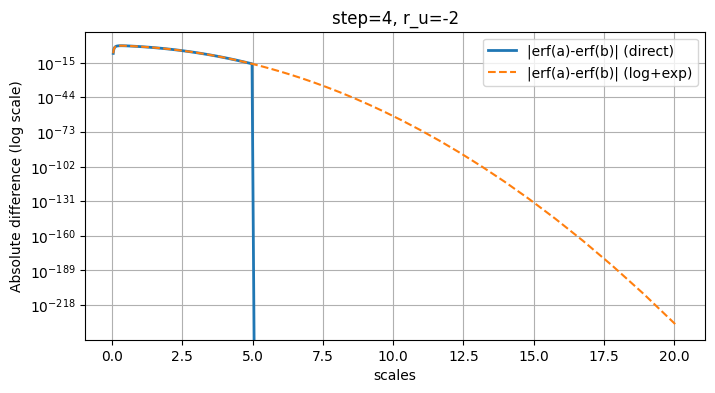

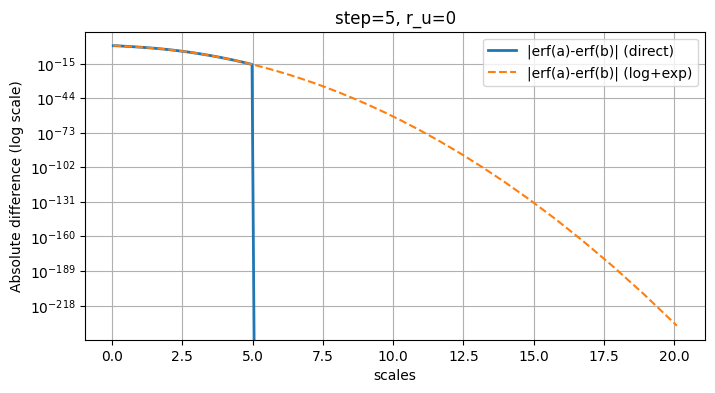

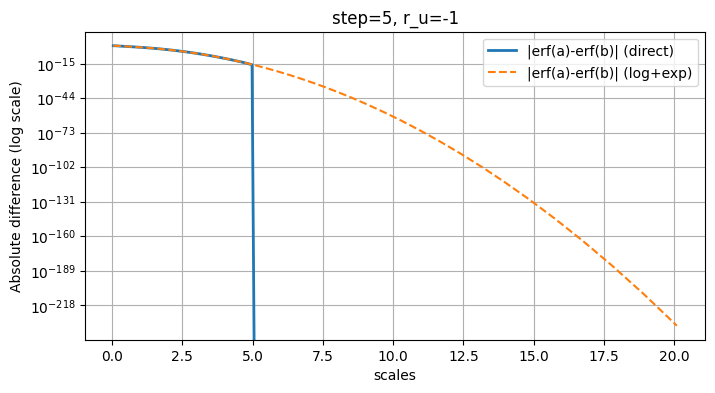

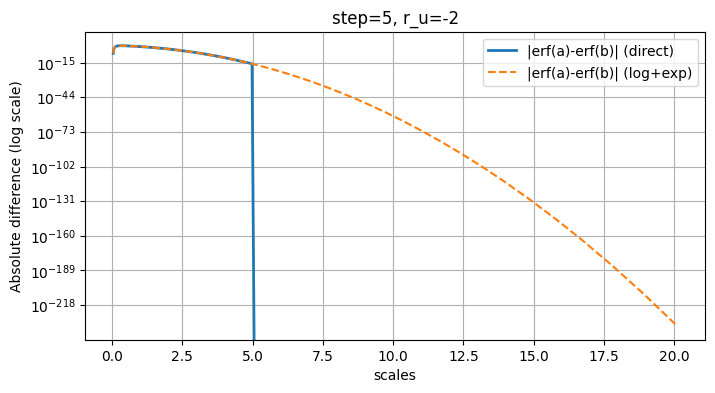

In [18]:
import numpy as np
from scipy.special import erf, erfcx
import matplotlib.pyplot as plt
import math

# -------------------------------------------
# (A) 로그+복원 기법
def _log_erfc_scalar(x, threshold=5.0):
    if x >= threshold:
        return math.log(erfcx(x)) - x*x
    elif x <= -threshold:
        y = -x
        log_neg = math.log(erfcx(y)) - y*y
        if log_neg < -700:
            return math.log(2.0)
        tmp = 2.0 - math.exp(log_neg)
        if tmp<=0:
            return float('-inf')
        return math.log(tmp)
    else:
        val= math.erfc(x)
        if val<=0:
            return float('-inf')
        return math.log(val)

def _stable_erfc_diff_scalar(a, b, threshold=5.0):
    La= _log_erfc_scalar(a, threshold)
    Lb= _log_erfc_scalar(b, threshold)
    if math.isinf(La) and math.isinf(Lb):
        return 0.0
    if Lb>La:
        Lbig, Lsmall= Lb, La
        sign= +1.0
    else:
        Lbig, Lsmall= La, Lb
        sign= -1.0
    if math.isinf(Lbig):
        return sign* math.exp(Lsmall)
    inside= 1.0- math.exp(Lsmall- Lbig)
    if inside==0.0:
        return 0.0
    elif inside<0.0:
        return -sign* math.exp(Lbig)*abs(inside)
    else:
        return sign* math.exp(Lbig)* inside

def stable_erf_diff(a, b, threshold=5.0):
    fvec= np.vectorize(lambda x,y: _stable_erfc_diff_scalar(x,y,threshold))
    return fvec(a,b)

# -------------------------------------------
# (B) 데모 코드
lambda_0 = -5.0778
lambda_1 =  5.7618
NFE = 25
delta_lambda = (lambda_1 - lambda_0) / NFE

log_scales = np.linspace(-3, 3, 100)
scales = np.exp(log_scales)       # e^-3 ~ e^3
betas = (1./scales) * delta_lambda   # shape=(100,)

for step in range(4, 6):
    for r_u in [0, -1, -2]:
        lambda_s = lambda_0 + delta_lambda * step
        lambda_t = lambda_0 + delta_lambda * (step+1)
        lambda_u = lambda_t + delta_lambda * r_u

        # a,b도 betas와 같은 shape= (100,) 이 됨
        a = betas*(lambda_t - lambda_u) + 1./(2*betas)
        b = betas*(lambda_s - lambda_u) + 1./(2*betas)

        # (1) direct: scipy.special.erf(a)-erf(b)
        diff_direct = erf(a) - erf(b)
        # (2) log+복원: stable_erf_diff
        diff_stable = stable_erf_diff(a, b, threshold=5.0)

        # 플롯
        plt.figure(figsize=[8, 4])
        plt.plot(scales, np.abs(diff_direct), label='|erf(a)-erf(b)| (direct)', lw=2)
        plt.plot(scales, np.abs(diff_stable), label='|erf(a)-erf(b)| (log+exp)', ls='--')

        plt.grid(True)
        plt.legend()
        plt.yscale('log')
        #plt.ylim([1e-35, 1])  
        plt.xlabel("scales")
        plt.ylabel("Absolute difference (log scale)")
        plt.title(f"step={step}, r_u={r_u}")
        plt.show()


In [77]:
import numpy as np
from scipy.special import erf, erfc
import matplotlib.pyplot as plt

# -------------------------------------------
# (B) 데모 코드
lambda_0 = -5.0778
lambda_1 =  5.7618

for NFE in range(5, 6):
    print('NFE :', NFE)
    delta_lambda = (lambda_1 - lambda_0) / NFE

    log_scales = np.linspace(-1, 1, 10)
    scales = np.exp(log_scales)       # e^-3 ~ e^3
    betas = (1./scales) * delta_lambda   # shape=(100,)

    def get_erf_diff(a, b, threshold=0):
        d1 = erfc(b)*(1 - np.exp(np.log(erfc(a)) - np.log(erfc(b))))
        d2 = -erfc(-b)*(1 - np.exp(np.log(erfc(-a)) - np.log(erfc(-b))))
        mask = (a < threshold) & (b < threshold)
        return np.where(mask, d2, d1)

    for step in range(0, NFE):
        for r_u in [0, -1, -2, -3]:
            lambda_s = lambda_0 + delta_lambda * step
            lambda_t = lambda_0 + delta_lambda * (step+1)
            lambda_u = lambda_t + delta_lambda * r_u

            # a,b도 betas와 같은 shape= (100,) 이 됨
            a = betas*(lambda_t - lambda_u) - 1./(2*betas)
            b = betas*(lambda_s - lambda_u) - 1./(2*betas)
            print(a)
            print(b)
            
            # (1) direct: scipy.special.erf(a)-erf(b)
            diff_direct = erf(a) - erf(b)
            # (2) log+복원: stable_erf_diff
            diff_stable = get_erf_diff(a, b)
            
            # # 플롯
            # plt.figure(figsize=[8, 4])
            # plt.plot(log_scales, np.abs(diff_direct), label='|erf(a)-erf(b)| (direct)', lw=2)
            # plt.plot(log_scales, np.abs(diff_stable), label='|erf(a)-erf(b)| (log+exp)', ls='--')
            
            # plt.grid(True)
            # plt.legend()
            # plt.yscale('log')
            # #plt.ylim([1e-35, 1])  
            # plt.xlabel("scales")
            # plt.ylabel("Absolute difference (log scale)")
            # plt.title(f"step={step}, r_u={r_u}")
            # plt.show()

print('done')

NFE : 5
[-0.08484618 -0.10596005 -0.13232809 -0.16525778 -0.206382   -0.25773992
 -0.32187821 -0.40197724 -0.50200882 -0.62693315]
[-12.86043676 -10.33585328  -8.32378622  -6.7244647   -5.45858431
  -4.46337476  -3.68948733  -3.09854782  -2.66125374  -2.35592132]
[12.69074441 10.12393318  8.05913005  6.39394913  5.04582031  3.94789491
  3.04573091  2.29459334  1.6572361   1.10205502]
[-0.08484618 -0.10596005 -0.13232809 -0.16525778 -0.206382   -0.25773992
 -0.32187821 -0.40197724 -0.50200882 -0.62693315]
[25.466335   20.35382641 16.25058818 12.95315604 10.29802262  8.15352975
  6.41334002  4.99116392  3.81648102  2.83104319]
[12.69074441 10.12393318  8.05913005  6.39394913  5.04582031  3.94789491
  3.04573091  2.29459334  1.6572361   1.10205502]
[38.24192559 30.58371964 24.44204632 19.51236296 15.55022493 12.35916459
  9.78094914  7.68773449  5.97572594  4.56003136]
[25.466335   20.35382641 16.25058818 12.95315604 10.29802262  8.15352975
  6.41334002  4.99116392  3.81648102  2.83104319

/tmp/ipykernel_583150/477581930.py:19: RuntimeWarning: divide by zero encountered in log
  d1 = erfc(b)*(1 - np.exp(np.log(erfc(a)) - np.log(erfc(b))))


/tmp/ipykernel_583150/3867546889.py:6: RuntimeWarning: divide by zero encountered in log
  d1 = erfc(b)*(1 - np.exp(np.log(erfc(a)) - np.log(erfc(b))))
/tmp/ipykernel_583150/3867546889.py:6: RuntimeWarning: invalid value encountered in subtract
  d1 = erfc(b)*(1 - np.exp(np.log(erfc(a)) - np.log(erfc(b))))


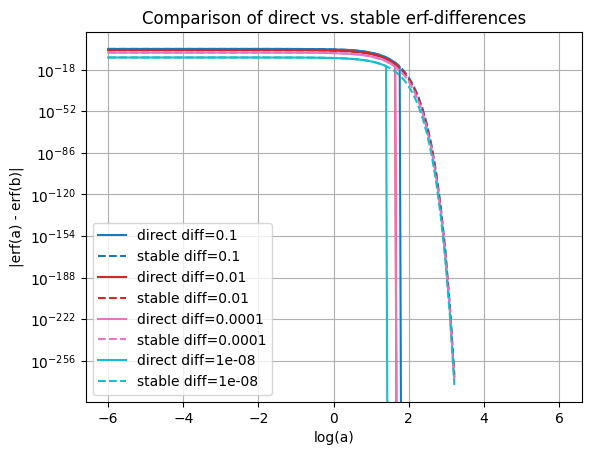

In [78]:
import numpy as np
from scipy.special import erf, erfc
import matplotlib.pyplot as plt

def get_erf_diff(a, b, threshold=0):
    d1 = erfc(b)*(1 - np.exp(np.log(erfc(a)) - np.log(erfc(b))))
    d2 = -erfc(-b)*(1 - np.exp(np.log(erfc(-a)) - np.log(erfc(-b))))
    mask = (a < threshold) & (b < threshold)
    return np.where(mask, d2, d1)

log_a = np.linspace(-6, 6, 100)
a = np.exp(log_a)
diff_values = [1e-1, 1e-2, 1e-4, 1e-8]

# 색상 팔레트 준비 (예: 4개의 diff에 대해)
colors = plt.cm.tab10(np.linspace(0, 1, len(diff_values)))

plt.figure()
for i, diff in enumerate(diff_values):
    b = a - diff
    erf_diff_direct = erf(a) - erf(b)
    erf_diff_stable = get_erf_diff(a, b)

    # direct: 실선
    plt.plot(log_a, np.abs(erf_diff_direct), 
             color=colors[i],
             label=f"direct diff={diff}")

    # stable: 점선
    plt.plot(log_a, np.abs(erf_diff_stable),
             linestyle="--",
             color=colors[i],
             label=f"stable diff={diff}")

plt.yscale("log")
plt.xlabel("log(a)")
plt.ylabel("|erf(a) - erf(b)|")
plt.title("Comparison of direct vs. stable erf-differences")
plt.grid(True)
plt.legend()
plt.show()
